In [1]:
import pandas as pd
from tqdm import tqdm

In [8]:
threshold = '0.99'
dataset = 'structural_similarity'

test = pd.read_csv(f'./{dataset}/test_rows_structural.csv', index_col=0)
train = pd.read_csv(f'./{dataset}/train_rows_structural_{threshold}.csv', index_col=0)

In [3]:
train.loc[train.spectrum_id.isin(test.spectrum_id)]

,scan,spectrum_id,collision_energy,Adduct,Compound_Source,Compund_Name,Precursor_MZ,ExactMass,Charge,Ion_Mode,...,msMassAnalyzer,msIonisation,msDissociationMethod,GNPS_library_membership,ppmBetweenExpAndThMass,Morgan_2048_2,Morgan_4096_2,Morgan_2048_3,Morgan_4096_3,InChIKey_smiles_14


In [4]:
test.loc[test.spectrum_id.isin(train.spectrum_id)]

,scan,spectrum_id,collision_energy,Adduct,Compound_Source,Compund_Name,Precursor_MZ,ExactMass,Charge,Ion_Mode,...,msMassAnalyzer,msIonisation,msDissociationMethod,GNPS_library_membership,ppmBetweenExpAndThMass,Morgan_2048_2,Morgan_4096_2,Morgan_2048_3,Morgan_4096_3,InChIKey_smiles_14


In [19]:
train = train.loc[~train.Morgan_2048_3.isna()]
test = test.loc[~test.Morgan_2048_3.isna()]

In [9]:
# Check for overlap using Morgan Fingerprints
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity, CreateFromBitString

from rdkit import DataStructs

# train.Morgan_2048_2 = train.Morgan_2048_2.apply(lambda x:  CreateFromBitString(''.join(str(y) for y in x)))
# train.Morgan_2048_3 = train.Morgan_2048_3.apply(lambda x:  CreateFromBitString(''.join(str(y) for y in x)))
train.Morgan_2048_3 = train.Smiles.apply(lambda x:  AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 3))
# train.Morgan_4096_2 = train.Morgan_4096_2.apply(lambda x:  CreateFromBitString(''.join(str(y) for y in x)))
# train.Morgan_4096_3 = train.Morgan_4096_3.apply(lambda x:  CreateFromBitString(''.join(str(y) for y in x)))

# test.Morgan_2048_2 = test.Morgan_2048_2.apply(lambda x:  CreateFromBitString(''.join(str(y) for y in x)))
# test.Morgan_2048_3 = test.Morgan_2048_3.apply(lambda x:  CreateFromBitString(''.join(str(y) for y in x)))
test.Morgan_2048_3 = test.Smiles.apply(lambda x:  AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 3))
# test.Morgan_4096_2 = test.Morgan_4096_2.apply(lambda x:  CreateFromBitString(''.join(str(y) for y in x)))
# test.Morgan_4096_3 = test.Morgan_4096_3.apply(lambda x:  CreateFromBitString(''.join(str(y) for y in x)))

In [10]:
import numpy as np
sims = []
problem_ids = []
train_fps = train.Morgan_2048_3
test_fps = list(test.Morgan_2048_3)

for idx in tqdm(range(len(train))):
    these_sims = DataStructs.BulkTanimotoSimilarity(train_fps.iloc[idx], test_fps)
    sims.extend(these_sims)
    max_index = np.argmax(these_sims)
    if these_sims[max_index] > float(threshold):
        problem_ids.append((train.spectrum_id.iloc[idx], these_sims[max_index], test.spectrum_id.iloc[max_index] ))

100%|██████████| 103126/103126 [00:43<00:00, 2349.79it/s]


In [11]:
pd.Series(sims).describe()

count    5.523429e+08
mean     8.078000e-02
std      4.901852e-02
min      0.000000e+00
25%      5.263158e-02
50%      7.329843e-02
75%      9.708738e-02
max      9.882353e-01
dtype: float64

In [30]:
train.loc[train.spectrum_id == "CCMSLIB00004706905"]

,scan,spectrum_id,collision_energy,Adduct,Compound_Source,Compund_Name,Precursor_MZ,ExactMass,Charge,Ion_Mode,...,msManufacturer,msMassAnalyzer,msIonisation,msDissociationMethod,GNPS_library_membership,ppmBetweenExpAndThMass,Morgan_2048_2,Morgan_4096_2,Morgan_2048_3,Morgan_4096_3
302529,387140,CCMSLIB00004706905,NaN,[M+Na]1+,isolated,"[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxym...",689.387,666.397913,1,positive,...,NaN,ftms,NaN,NaN,MONA,0.199542,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [31]:
test.loc[test.spectrum_id == "CCMSLIB00006362333"]

,scan,spectrum_id,collision_energy,Adduct,Compound_Source,Compund_Name,Precursor_MZ,ExactMass,Charge,Ion_Mode,...,msManufacturer,msMassAnalyzer,msIonisation,msDissociationMethod,GNPS_library_membership,ppmBetweenExpAndThMass,Morgan_2048_2,Morgan_4096_2,Morgan_2048_3,Morgan_4096_3
380,136381,CCMSLIB00006362333,NaN,[M+Na]1+,commercial,Chlorogenic acid,377.08,354.095082,1,positive,...,Thermo,orbitrap,ESI,NaN,BMDMS-NP,11.419934,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


<Axes: >

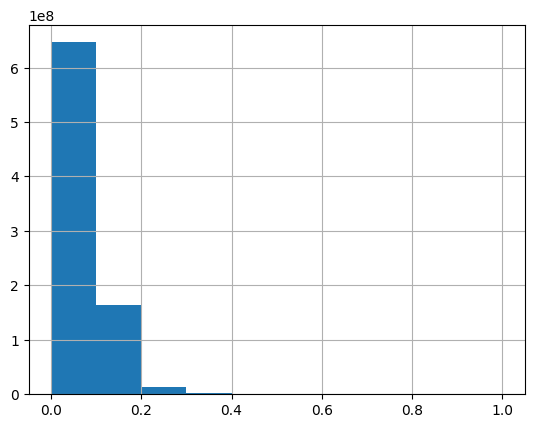

In [9]:
pd.Series(sims).hist()

<Axes: >

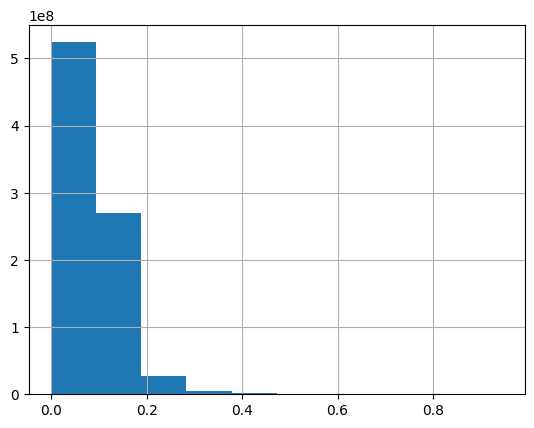

In [33]:
pd.Series(sims).hist()

In [34]:
problem_ids

[('CCMSLIB00004706905', 0.8392857142857143, 'CCMSLIB00004688032'),
 ('CCMSLIB00004704480', 0.7126436781609196, 'CCMSLIB00006364369'),
 ('CCMSLIB00005724720', 0.6022099447513812, 'CCMSLIB00004693487'),
 ('CCMSLIB00010007892', 0.6794871794871795, 'CCMSLIB00010114773'),
 ('CCMSLIB00006684182', 0.6190476190476191, 'CCMSLIB00006118274'),
 ('CCMSLIB00005721272', 0.8125, 'CCMSLIB00006425939'),
 ('CCMSLIB00010114799', 0.7523809523809524, 'CCMSLIB00010116910'),
 ('CCMSLIB00011906552', 0.8666666666666667, 'CCMSLIB00011906447'),
 ('CCMSLIB00004699409', 0.8596491228070176, 'CCMSLIB00000850257'),
 ('CCMSLIB00011429513', 0.7355371900826446, 'CCMSLIB00009919447'),
 ('CCMSLIB00006531862', 0.7929515418502202, 'CCMSLIB00006517549'),
 ('CCMSLIB00006581890', 0.6923076923076923, 'CCMSLIB00004717431'),
 ('CCMSLIB00010121981', 0.7711864406779662, 'CCMSLIB00010121551'),
 ('CCMSLIB00011435770', 0.7391304347826086, 'CCMSLIB00011435166'),
 ('CCMSLIB00010114083', 0.7111111111111111, 'CCMSLIB00010112953'),
 ('CCMS

In [11]:
pd.Series(sims)[pd.Series(sims) > 0.9]

336          1.0
2546         1.0
3289         1.0
5540         1.0
6216         1.0
            ... 
827616826    1.0
827619124    1.0
827620205    1.0
827621494    1.0
827621682    1.0
Length: 280932, dtype: float64

## Data Sanity Checks

In [7]:
import matchms
from matchms.filtering import add_fingerprint

In [69]:
test_set = list(matchms.importing.load_from_mgf("./structural_similarity/raw/train_rows.mgf"))
# Filter peaks to have relative intensities > 0.05
# test_set = [matchms.filtering.select_by_relative_intensity(x, intensity_from=0.001) for x in test_set]
# Remove spectra with less than 10
# test_set = [matchms.filtering.require_minimum_of_high_peaks(x, no_peaks=5, intensity_percent=5) for x in test_set]
# Count total 'None'
# print(sum([x is None for x in test_set]))
# Remove spectra with 'None'
test_set = [x for x in test_set if x is not None]

test_set = [add_fingerprint(x) for x in test_set]

representative_spectra = {s.get("smiles")[:14]: s for s in test_set}

In [70]:
print(len(test_set))

156345


In [72]:
print(len(representative_spectra))
test_set = list(representative_spectra.values())

6159


In [73]:
# Calculate the pairwise similarity between all spectra in the test set
from matchms.similarity import ModifiedCosine, CosineHungarian, CosineGreedy
from matchms import calculate_scores
import numpy as np
from tqdm import tqdm

modified_cosine = ModifiedCosine(tolerance=0.005)
# modified_cosine = CosineGreedy()
modified_cosine_values = modified_cosine.matrix(test_set, test_set, is_symmetric=True)


In [74]:
o = calculate_scores(test_set, test_set, modified_cosine)

In [75]:
o.score_names

('ModifiedCosine_score', 'ModifiedCosine_matches')

In [36]:
modified_cosine_values['matches']

array([[ 99,   0,   2, ...,   0,   0,   0],
       [  0,  79,   2, ...,   0,   0,   0],
       [  2,   2, 214, ...,   0,   2,   0],
       ...,
       [  0,   0,   0, ...,  24,   2,   4],
       [  0,   0,   2, ...,   2,  14,   0],
       [  0,   0,   0, ...,   4,   0,  18]])

In [76]:
modified_cosine_scores = modified_cosine_values['score']
modified_cosine_matches = modified_cosine_values['matches']
modified_cosine_scores[modified_cosine_matches<10] = -2

no_diag_modified_cosine_values = modified_cosine_scores - np.eye(len(modified_cosine_scores))

highest_modified_cosine_indices = np.unravel_index(np.argsort(no_diag_modified_cosine_values.ravel())[-50:], modified_cosine_scores.shape)
highest_modified_cosine_indices

# Print the pairs smiles at each index
for i, j in zip(*highest_modified_cosine_indices):
    print(test_set[i].metadata.get("smiles"), test_set[j].metadata.get("smiles"), no_diag_modified_cosine_values[i, j], test_set[i].metadata.get("spectrum_id"), test_set[j].metadata.get("spectrum_id"))

C=CCN(C(=O)CSc1nc2c(=O)[nH]cnc2n1-c1ccccc1)c1ccccc1 CCc1ccc(NC(=O)CSc2nc3c(=O)[nH]cnc3n2-c2ccccc2)cc1 0.9992150953406701 CCMSLIB00010121492 CCMSLIB00010123899
CCc1ccc(NC(=O)CSc2nc3c(=O)[nH]cnc3n2-c2ccccc2)cc1 C=CCN(C(=O)CSc1nc2c(=O)[nH]cnc2n1-c1ccccc1)c1ccccc1 0.9992150953406701 CCMSLIB00010123899 CCMSLIB00010121492
Cc1ccc(Cl)cc1NC(=O)CSc1nc2c(=O)[nH]cnc2n1C CC(=O)c1ccc(NC(=O)CSc2nc3c(=O)[nH]cnc3n2C)cc1 0.9992187730960682 CCMSLIB00010123825 CCMSLIB00010123947
CC(=O)c1ccc(NC(=O)CSc2nc3c(=O)[nH]cnc3n2C)cc1 Cc1ccc(Cl)cc1NC(=O)CSc1nc2c(=O)[nH]cnc2n1C 0.9992187730960682 CCMSLIB00010123947 CCMSLIB00010123825
CSc1cccc(NC(=O)CSc2nc3c(=O)[nH]cnc3n2-c2ccc(C)cc2)c1 COc1ccccc1NC(=O)CSc1nc2c(=O)[nH]cnc2n1-c1ccc(C)cc1 0.9993225967196303 CCMSLIB00010124174 CCMSLIB00010122997
COc1ccccc1NC(=O)CSc1nc2c(=O)[nH]cnc2n1-c1ccc(C)cc1 CSc1cccc(NC(=O)CSc2nc3c(=O)[nH]cnc3n2-c2ccc(C)cc2)c1 0.9993225967196303 CCMSLIB00010122997 CCMSLIB00010124174
CCc1ccc(NC(=O)CSc2nc3c(=O)[nH]cnc3n2-c2ccccc2)cc1 Cc1ccc(NC(=O)CSc2n

O=C(OCC1OC(OC2COC(CO)C(O)C2O)C(O)C(O)C1O)c1ccccc1
O=C(OCC1=CC(Cl)C(O)C(OC(=O)c2ccccc2)C1O)c1ccccc1
(0.96427409, 17)
0.41386554621848737


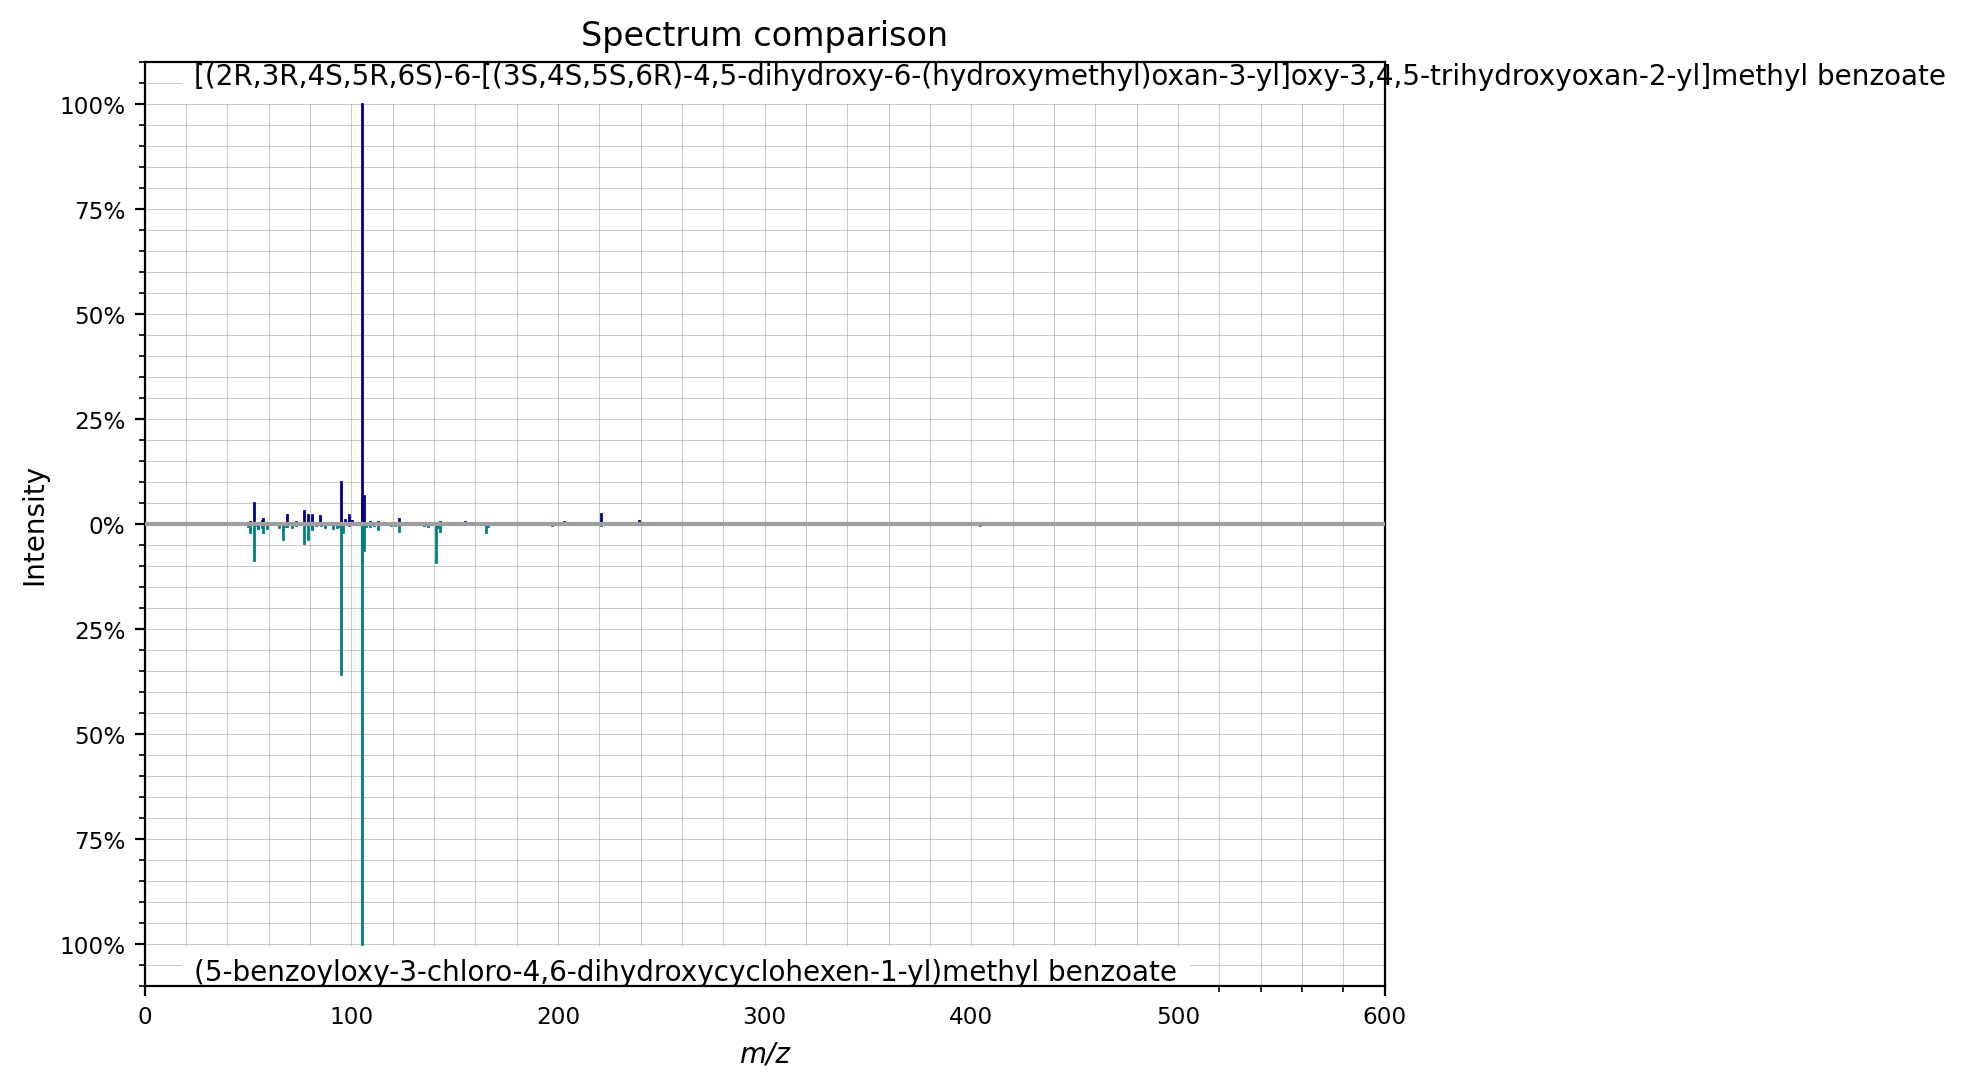

In [57]:
# Plot the spectra
import pickle
spectrum_id_1 = "CCMSLIB00004709501"
spectrum_id_2 = "CCMSLIB00004692959"

spec_1 = [s for s in test_set if s.metadata.get("spectrum_id") == spectrum_id_1]
spec_2 = [s for s in test_set if s.metadata.get("spectrum_id") == spectrum_id_2]

assert len(spec_1) == 1
assert len(spec_2) == 1

spec_1 = spec_1[0]
spec_2 = spec_2[0]

# pickle.dump(spec_1, open("spec_1.pkl", "wb"))
# pickle.dump(spec_2, open("spec_2.pkl", "wb"))

print(spec_1.metadata.get("smiles"))
print(spec_2.metadata.get("smiles"))

spec_1.plot_against(spec_2)
# Get the cosine
print(modified_cosine.pair(spec_1, spec_2))
print(fp_sim.pair(spec_1, spec_2))

In [77]:
# Caluclate the pairwise tanimoto similarity
from matchms.similarity.FingerprintSimilarity import FingerprintSimilarity
fp_sim = FingerprintSimilarity("jaccard")
jaccard_similarity = calculate_scores(test_set, test_set, similarity_function=fp_sim).to_array(name='FingerprintSimilarity')

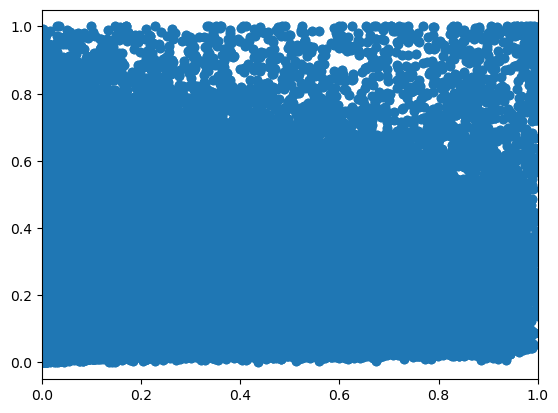

In [78]:
import matplotlib.pyplot as plt

# Set diagonal to -1
np.fill_diagonal(modified_cosine_scores, -1)
np.fill_diagonal(jaccard_similarity, -1)

# Get flattened arrays without diagonal
modified_cosine_local = modified_cosine_scores.flatten()
jaccard_similarity = jaccard_similarity.flatten()
modified_cosine_local = modified_cosine_local[modified_cosine_local != -1]
jaccard_similarity = jaccard_similarity[jaccard_similarity != -1]
plt.xlim(0,1)
plt.scatter(modified_cosine_local, jaccard_similarity)

Text(0, 0.5, 'Jaccard Similarity')

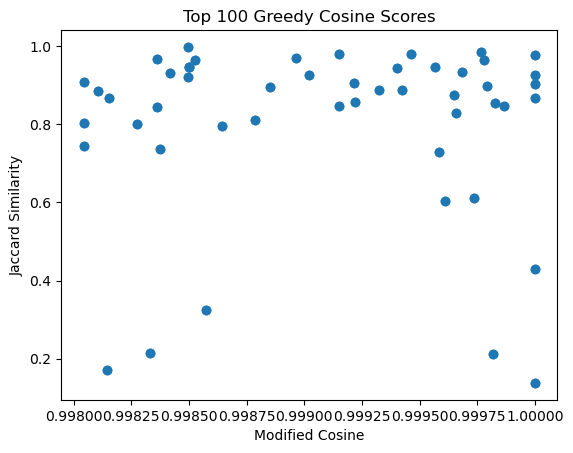

In [79]:
# Get highest 100 cosine scores and plot against jaccard similarity
import numpy as np
top_100_indices = np.argsort(modified_cosine_local)[-100:]

plt.figure()
plt.title("Top 100 Greedy Cosine Scores")
plt.scatter(modified_cosine_local[top_100_indices], jaccard_similarity[top_100_indices])
plt.xlabel("Modified Cosine")
plt.ylabel("Jaccard Similarity")

In [58]:
len(modified_cosine_local)

558756

In [60]:
modified_cosine_local[top_100_indices]

array([0.83121133, 0.83121133, 0.83158545, 0.83158545, 0.83634419,
       0.83634419, 0.83795772, 0.83795772, 0.83853726, 0.83853726,
       0.83930027, 0.83930027, 0.84174396, 0.84174396, 0.84294027,
       0.84294027, 0.84689901, 0.84689901, 0.84693602, 0.84693602,
       0.84724451, 0.84724451, 0.85099767, 0.85099767, 0.85107125,
       0.85107125, 0.85192898, 0.85192898, 0.85204972, 0.85204972,
       0.8522146 , 0.8522146 , 0.85332693, 0.85332693, 0.8547994 ,
       0.8547994 , 0.85954736, 0.85954736, 0.85958132, 0.85958132,
       0.85966505, 0.85966505, 0.86197603, 0.86197603, 0.86234635,
       0.86234635, 0.86265005, 0.86265005, 0.86469028, 0.86469028,
       0.86777413, 0.86777413, 0.86794074, 0.86794074, 0.86794382,
       0.86794382, 0.86943337, 0.86943337, 0.87069429, 0.87069429,
       0.87149535, 0.87149535, 0.87183737, 0.87183737, 0.87201422,
       0.87201422, 0.87316646, 0.87316646, 0.87414672, 0.87414672,
       0.87529062, 0.87529062, 0.87546402, 0.87546402, 0.87699